In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import wisc_ecephys_tools as wet
from ecephys import hypnogram
import findlay2025a as f25a
from findlay2025a.constants import Experiments as Exps

In [3]:
nb = wet.get_sglx_project("seahorse")

In [4]:
def get_nrem_rem_nrem_sandwiches(
    hg: hypnogram.FloatHypnogram,
) -> list[hypnogram.FloatHypnogram]:
    sandwiches = []
    i = 0
    while i < len(hg):
        j = i
        while j < len(hg) and hg.iloc[i : j + 1]["state"].isin(["NREM"]).all():
            j += 1
        if j == i:  # No NREM was found
            i += 1
            continue
        k = j
        while k < len(hg) and hg.iloc[j : k + 1]["state"].isin(["IS", "REM"]).all():
            k += 1
        if k == j:  # No IS or REM was found
            i = k + 1
            continue
        l = k
        while l < len(hg) and hg.iloc[k : l + 1]["state"].isin(["NREM"]).all():
            l += 1
        if l == k:  # No NREM was found
            i = l + 1
            continue
        sandwiches.append(hg.iloc[i:l])
        i = k  # Because the start of NREM2 could be the start of the next NREM1.
    return [
        hypnogram.FloatHypnogram(s)
        for s in sandwiches
        if s["state"].isin(["REM"]).any()
    ]


In [5]:
def extract_sandwich_parts(
    sandwich: hypnogram.FloatHypnogram,
) -> tuple[
    hypnogram.FloatHypnogram, hypnogram.FloatHypnogram, hypnogram.FloatHypnogram
]:
    i = j = 0
    while j < len(sandwich) and sandwich.iloc[i : j + 1]["state"].isin(["NREM"]).all():
        j += 1
    top = hypnogram.FloatHypnogram(sandwich.iloc[i:j])

    k = j
    while (
        k < len(sandwich)
        and sandwich.iloc[j : k + 1]["state"].isin(["IS", "REM"]).all()
    ):
        k += 1
    middle = hypnogram.FloatHypnogram(sandwich.iloc[j:k])

    l = k
    while l < len(sandwich) and sandwich.iloc[k : l + 1]["state"].isin(["NREM"]).all():
        l += 1
    bottom = hypnogram.FloatHypnogram(sandwich.iloc[k:l])

    return top, middle, bottom

In [6]:
def extract_sandwich_properties(
    sandwich: hypnogram.FloatHypnogram,
    spws: pd.DataFrame,
    nrem_duration_limit: float = None,
) -> pd.DataFrame:
    top, middle, bottom = extract_sandwich_parts(sandwich)
    if nrem_duration_limit is not None:
        top = top.keep_last(nrem_duration_limit, trim=True)
        bottom = bottom.keep_first(nrem_duration_limit, trim=True)
    pre_spws = spws[top.covers_time(spws["start_time"])]
    pre_props = {
        "NREM1 duration (s)": top["duration"].sum(),
        "NREM1 SPW count": len(pre_spws),
        "NREM1 SPW amplitude (Z)": pre_spws["zlog_amp"].mean(),
        "NREM1 SPW rate (Hz)": len(pre_spws) / top["duration"].sum(),
    }
    ist = middle.keep_states(["IS"])
    ist_spws = spws[ist.covers_time(spws["start_time"])]
    with np.errstate(divide="ignore", invalid="ignore"):
        ist_props = {
            "IS duration (s)": ist["duration"].sum(),
            "IS SPW count": len(ist_spws),
            "IS SPW amplitude (Z)": ist_spws["zlog_amp"].mean(),
            "IS SPW rate (Hz)": len(ist_spws) / ist["duration"].sum(),
        }
    rem = middle.keep_states(["REM"])
    rem_spws = spws[rem.covers_time(spws["start_time"])]
    rem_props = {
        "REM start time (s)": rem["start_time"].min(),
        "REM duration (s)": rem["duration"].sum(),
        "REM SPW count": len(rem_spws),
        "REM SPW amplitude (Z)": rem_spws["zlog_amp"].mean(),
        "REM SPW rate (Hz)": len(rem_spws) / rem["duration"].sum(),
    }
    post_spws = spws[bottom.covers_time(spws["start_time"])]
    post_props = {
        "NREM2 duration (s)": bottom["duration"].sum(),
        "NREM2 SPW count": len(post_spws),
        "NREM2 SPW amplitude (Z)": post_spws["zlog_amp"].mean(),
        "NREM2 SPW rate (Hz)": len(post_spws) / bottom["duration"].sum(),
    }
    df = pd.DataFrame({**pre_props, **ist_props, **rem_props, **post_props}, index=[0])
    df["NREM2-NREM1 SPW amplitude (Z)"] = (
        df["NREM2 SPW amplitude (Z)"] - df["NREM1 SPW amplitude (Z)"]
    )
    df["NREM2-NREM1 SPW rate (Hz)"] = (
        df["NREM2 SPW rate (Hz)"] - df["NREM1 SPW rate (Hz)"]
    )
    df["NREM2-NREM1 duration (s)"] = df["NREM2 duration (s)"] - df["NREM1 duration (s)"]
    df["IS+REM duration (s)"] = df["IS duration (s)"] + df["REM duration (s)"]
    if not (pre_spws.empty or post_spws.empty):
        nrem_spws = pd.concat([pre_spws, post_spws], axis=0, ignore_index=True)
        lr = stats.linregress(nrem_spws["pk_time"], nrem_spws["zlog_amp"])
        df["NREM2-NREM1 SPW amplitude slope"] = lr.slope
        df["NREM2-NREM1 SPW amplitude slope p-value"] = lr.pvalue
        sr = stats.spearmanr(nrem_spws["pk_time"], nrem_spws["zlog_amp"])
        df["NREM2-NREM1 SPW amplitude Spearman's rho"] = sr.correlation
        df["NREM2-NREM1 SPW amplitude Spearman's p-value"] = sr.pvalue
    return df

In [7]:
def do_experiment(subject: str, experiment: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    # Load the conditions and their hypnograms.
    hgs = f25a.hypnograms.load_statistical_condition_hypnograms(
        experiment, subject, include_full_conservative=True
    )
    # Drop states that we do not want to contribute to global rate estimation.
    full_hg = hgs.pop("full_conservative")
    print(f"Size of full, simplified hypnogram: {len(full_hg)}")
    hg = full_hg.keep_states(["NREM", "IS", "REM", "Wake"])
    print(f"Size of hypnogram with only NREM, IS, REM, and Wake: {len(hg)}")
    hg = hypnogram.FloatHypnogram(hypnogram.condense(hg._df, 4))
    print(f"Size of condensed hypnogram: {len(hg)}")
    sandwiches = get_nrem_rem_nrem_sandwiches(hg)
    print(f"Number of NREM-REM-NREM sandwiches: {len(sandwiches)}")
    spws = f25a.sharp_waves.read_spws(subject, experiment)
    df = pd.concat(
        [extract_sandwich_properties(s, spws) for s in sandwiches],
        axis=0,
        ignore_index=True,
    )
    df_3min = pd.concat(
        [
            extract_sandwich_properties(s, spws, nrem_duration_limit=180)
            for s in sandwiches
        ],
        axis=0,
        ignore_index=True,
    )
    return df, df_3min

In [8]:
def do_project():
    df = pd.DataFrame()
    df_3min = pd.DataFrame()
    for subject, experiment in f25a.core.yield_subject_name_experiment_pairs():
        print(f"Doing {subject} {experiment}")
        _df, _df_3min = do_experiment(subject, experiment)
        _df["Subject"] = subject
        _df["Experiment"] = experiment
        _df_3min["Subject"] = subject
        _df_3min["Experiment"] = experiment
        df = pd.concat([df, _df], axis=0, ignore_index=True)
        df_3min = pd.concat([df_3min, _df_3min], axis=0, ignore_index=True)
    return df, df_3min

In [9]:
df, df_3min = do_project()

Doing CNPIX2-Segundo novel_objects_deprivation
Size of full, simplified hypnogram: 2518
Size of hypnogram with only NREM, IS, REM, and Wake: 1898
Size of condensed hypnogram: 1765
Number of NREM-REM-NREM sandwiches: 56
Doing CNPIX3-Valentino novel_objects_deprivation
Size of full, simplified hypnogram: 2826
Size of hypnogram with only NREM, IS, REM, and Wake: 2163
Size of condensed hypnogram: 1981
Number of NREM-REM-NREM sandwiches: 76
Doing CNPIX4-Doppio novel_objects_deprivation
Size of full, simplified hypnogram: 2016
Size of hypnogram with only NREM, IS, REM, and Wake: 1705
Size of condensed hypnogram: 1593
Number of NREM-REM-NREM sandwiches: 87
Doing CNPIX5-Alessandro novel_objects_deprivation
Size of full, simplified hypnogram: 2141
Size of hypnogram with only NREM, IS, REM, and Wake: 1698
Size of condensed hypnogram: 1526
Number of NREM-REM-NREM sandwiches: 47
Doing CNPIX6-Eugene novel_objects_deprivation
Size of full, simplified hypnogram: 1748
Size of hypnogram with only NREM,

In [10]:
for d in [df, df_3min]:
    d["Experiment"] = d["Experiment"].map(
        {Exps.NOD: "Novelty", Exps.COW: "Locomotion", Exps.CTN: "Dual"}
    )

In [11]:
exps = ["Novelty", "Locomotion", "Dual"]
m_exp = ["o", "^", "P"]
p_ = sns.color_palette("Dark2_r", 8)
p_exp = dict(zip(exps, p_))
p_

[(0.4, 0.4, 0.4),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)]

# SPW Amplitude

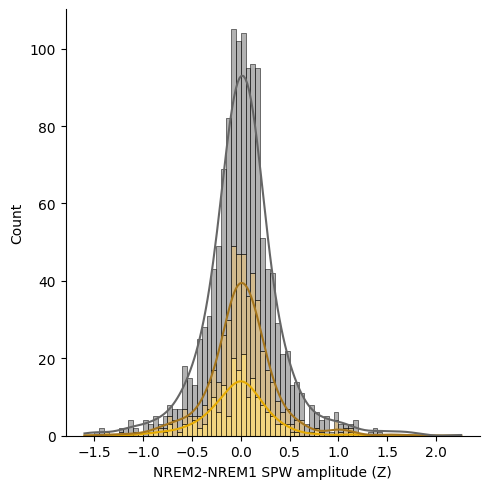

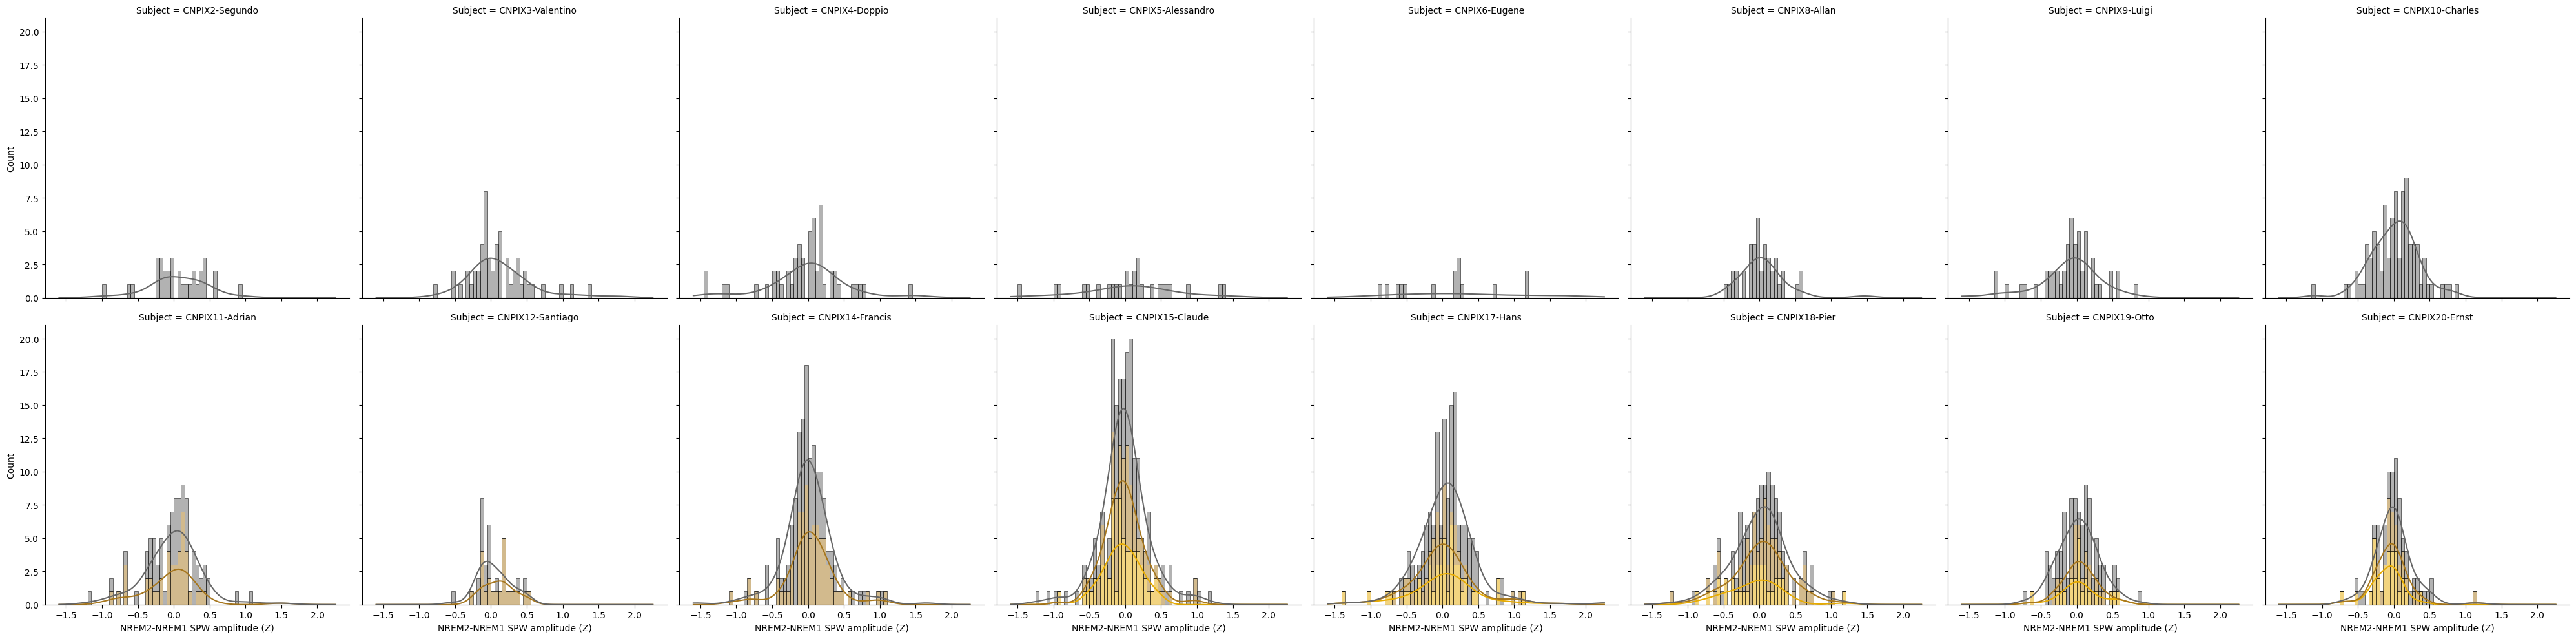

In [12]:
d = df
xvar = "NREM2-NREM1 SPW amplitude (Z)"
g = sns.displot(
    data=d,
    x=xvar,
    hue="Experiment",
    palette=p_exp,
    kind="hist",
    multiple="stack",
    kde=True,
    bins=np.arange(-1.5, 1.5, 0.05),
    legend=False,
)
g.savefig(nb.get_project_file("figures/spw_amplitude_rem_effect.png"), dpi=600)
sns.displot(
    data=d,
    x=xvar,
    hue="Experiment",
    palette=p_exp,
    kind="hist",
    multiple="stack",
    kde=True,
    bins=np.arange(-1.5, 1.5, 0.05),
    col="Subject",
    col_wrap=8,
    legend=False,
)

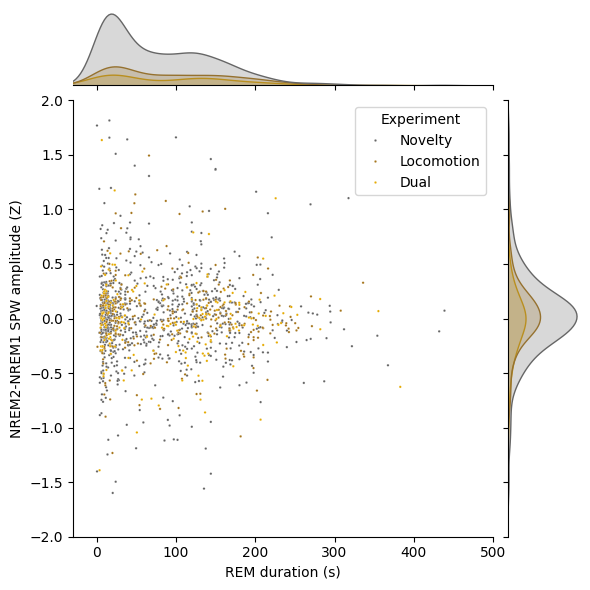

In [42]:
sns.jointplot(
    data=df,
    x="REM duration (s)",
    y="NREM2-NREM1 SPW amplitude (Z)",
    hue="Experiment",
    palette=p_exp,
    s=3,
    xlim=(-30, 500),
    ylim=(-2, 2),
)
plt.savefig(
    nb.get_project_file("figures/spw_amplitude_change_vs_rem_duration_joint.png"),
    dpi=600,
)

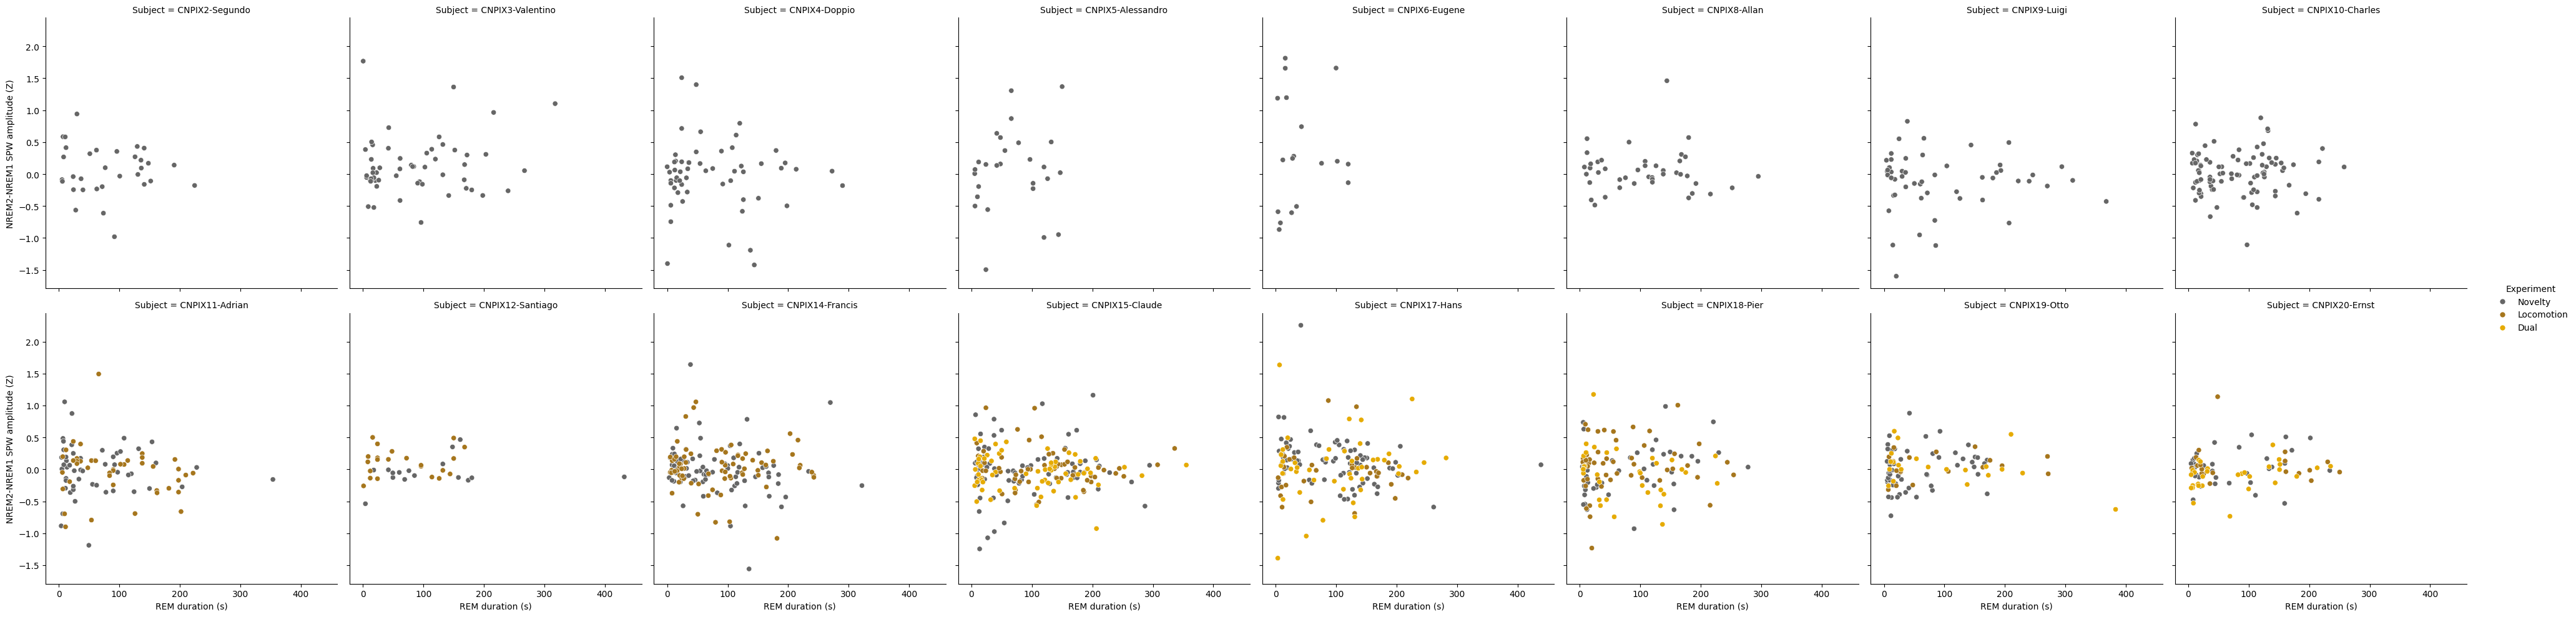

In [16]:
sns.relplot(
    data=df,
    x="REM duration (s)",
    y="NREM2-NREM1 SPW amplitude (Z)",
    col="Subject",
    col_wrap=8,
    hue="Experiment",
    palette=p_exp,
    kind="scatter",
)

# SPW Rate

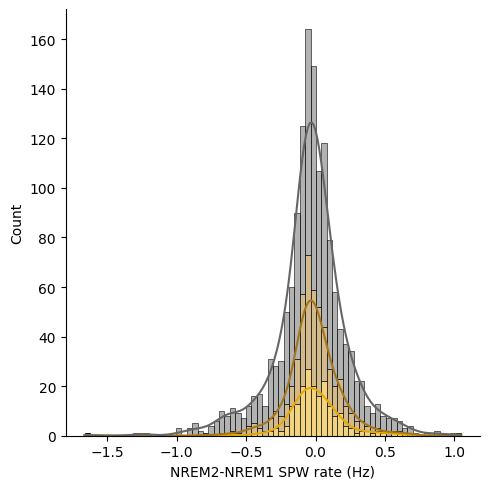

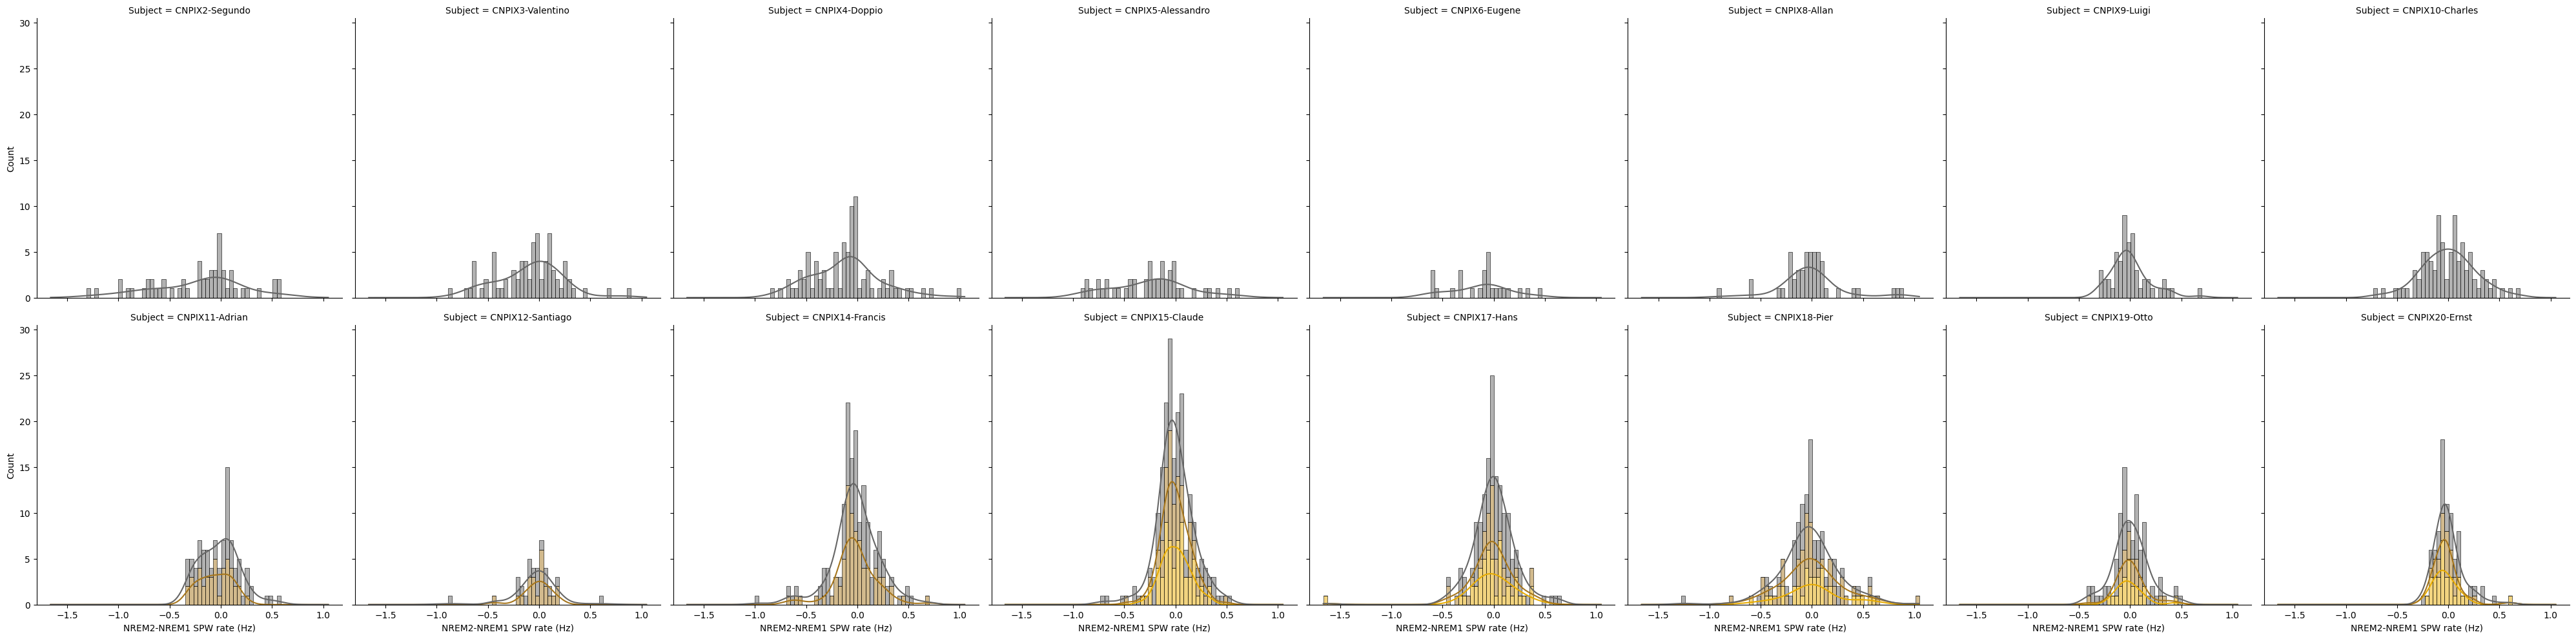

In [13]:
d = df
xvar = "NREM2-NREM1 SPW rate (Hz)"
g = sns.displot(
    data=d,
    x=xvar,
    hue="Experiment",
    palette=p_exp,
    kind="hist",
    multiple="stack",
    kde=True,
    legend=False,
)
g.savefig(nb.get_project_file("figures/spw_rate_rem_effect.png"), dpi=600)
sns.displot(
    data=d,
    x=xvar,
    hue="Experiment",
    palette=p_exp,
    kind="hist",
    multiple="stack",
    kde=True,
    col="Subject",
    col_wrap=8,
    legend=False,
)

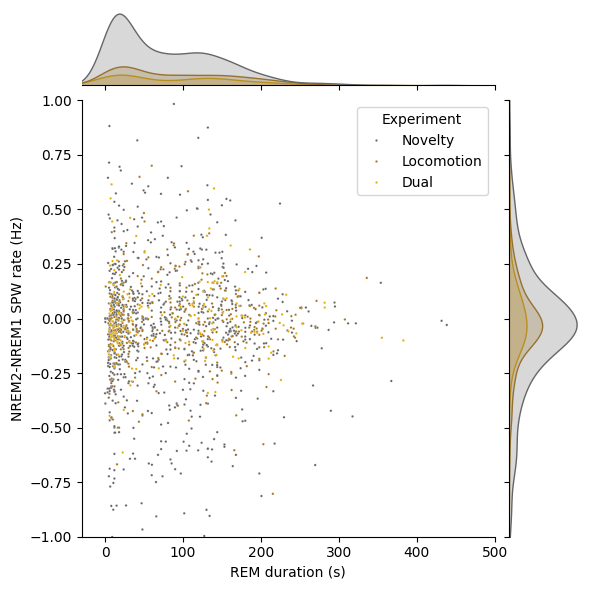

In [46]:
sns.jointplot(
    data=df,
    x="REM duration (s)",
    y="NREM2-NREM1 SPW rate (Hz)",
    hue="Experiment",
    palette=p_exp,
    s=3,
    xlim=(-30, 500),
    ylim=(-1, 1),
)
plt.savefig(
    nb.get_project_file("figures/spw_rate_change_vs_rem_duration_joint.png"), dpi=600
)

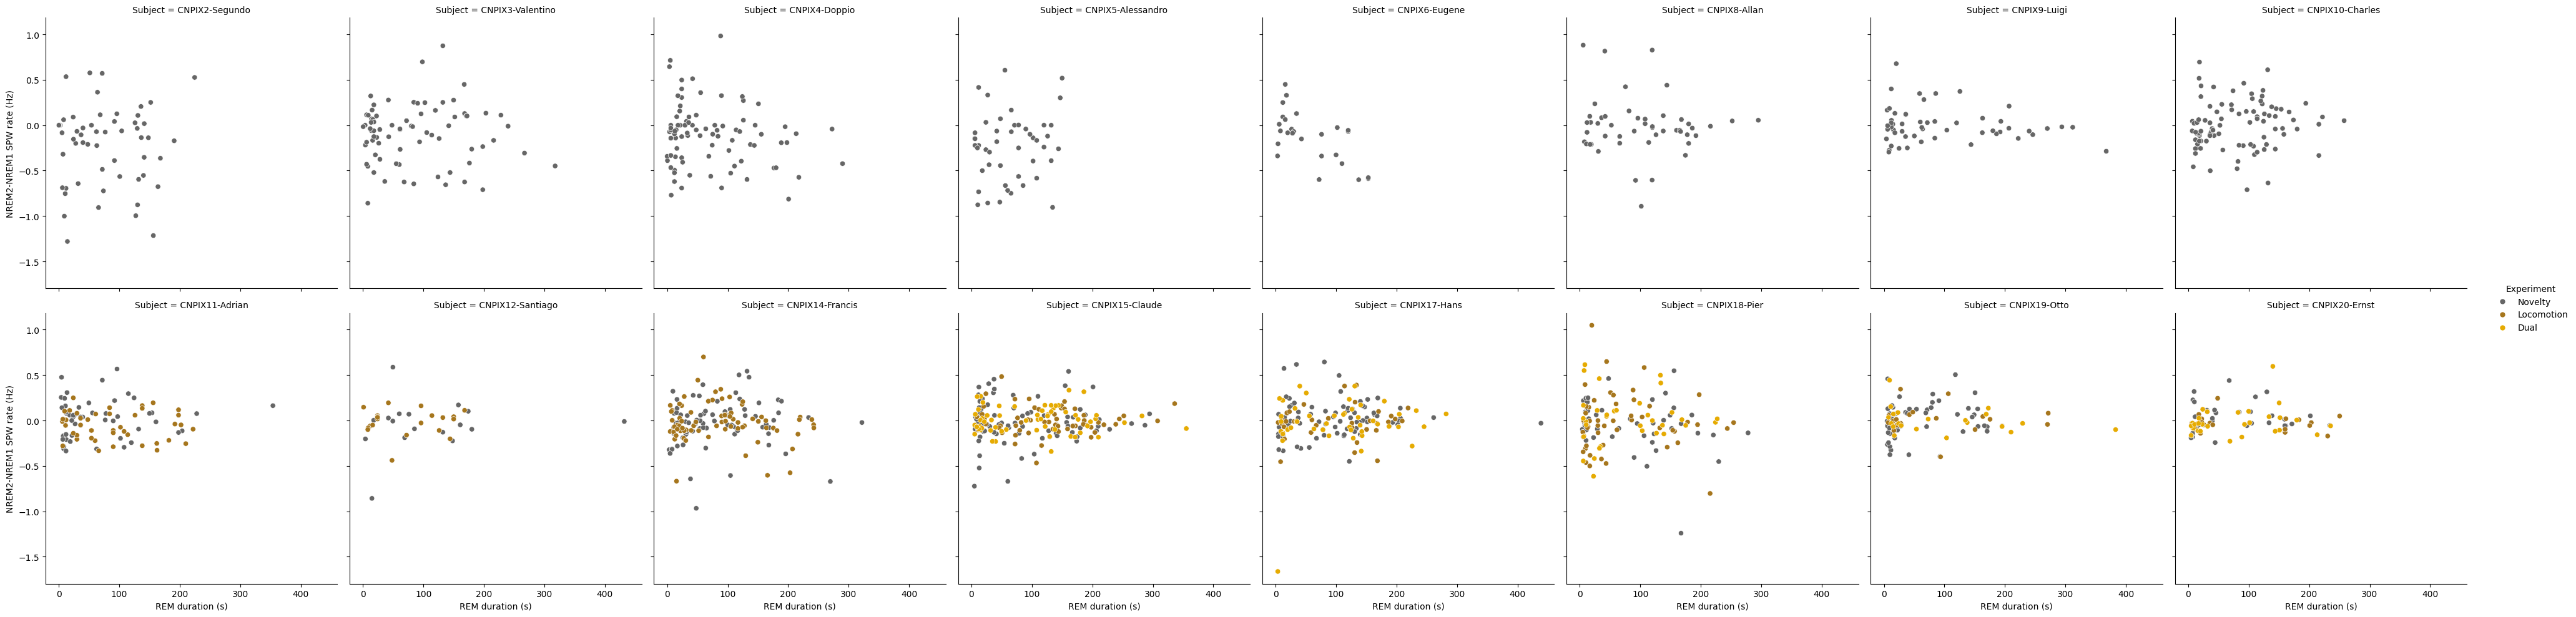

In [14]:
sns.relplot(
    data=df,
    x="REM duration (s)",
    y="NREM2-NREM1 SPW rate (Hz)",
    col="Subject",
    col_wrap=8,
    hue="Experiment",
    palette=p_exp,
    kind="scatter",
)